In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

import torch
from momentfm import MOMENTPipeline

/workspace/svi_momentts_imputing/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/svi_momentts_imputing/.venv/lib/python3.11/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
df = pd.read_csv("processed_reflectance.csv")
df_all = df.sort_values("timestamp").reset_index(drop=True)

spec_cols = [c for c in df_all.columns if c != "timestamp"]

df_all

,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16420,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16421,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16422,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16423,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
def plot_reflectance_heatmap(df, spectral_prefix="", 
                             wl_start=400, cmap="RdYlGn",
                             vmin=-0.075, vmax=0.275,
                             title="Reflectance Variation Over Time",
                             figsize=(10,7)):
    """
    Plot time × wavelength reflectance heatmap.
    df must contain a 'timestamp' column and spectral_bin_* columns.
    """

    if "timestamp" not in df.columns:
        raise ValueError("DataFrame must contain a 'timestamp' column.")

    # Spectral columns
    spec_cols = [c for c in df.columns if c != "timestamp"]
    if len(spec_cols) == 0:
        raise ValueError(f"No columns starting with '{spectral_prefix}' found.")

    # Convert values → matrix
    data = df[spec_cols].to_numpy()

    # Wavelength axis
    wl_end = wl_start + len(spec_cols) - 1
    wavelengths = np.arange(wl_start, wl_end + 1)

    # Date labels
    dates = pd.to_datetime(df["timestamp"]).dt.strftime("%Y-%m-%d")

    # Plot
    plt.figure(figsize=figsize)

    plt.imshow(
        data,
        aspect='auto',
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        extent=[wavelengths[0], wavelengths[-1], len(df), 0],
        origin='upper'      # time runs from top to bottom
    )

    plt.colorbar(label="Reflectance")

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Date")
    plt.title(title, fontsize=14)

    # Y-ticks → readable dates
    yticks = np.linspace(0, len(df)-1, 10).astype(int)
    plt.yticks(yticks, dates.iloc[yticks], rotation=0)

    plt.tight_layout()
    plt.show()

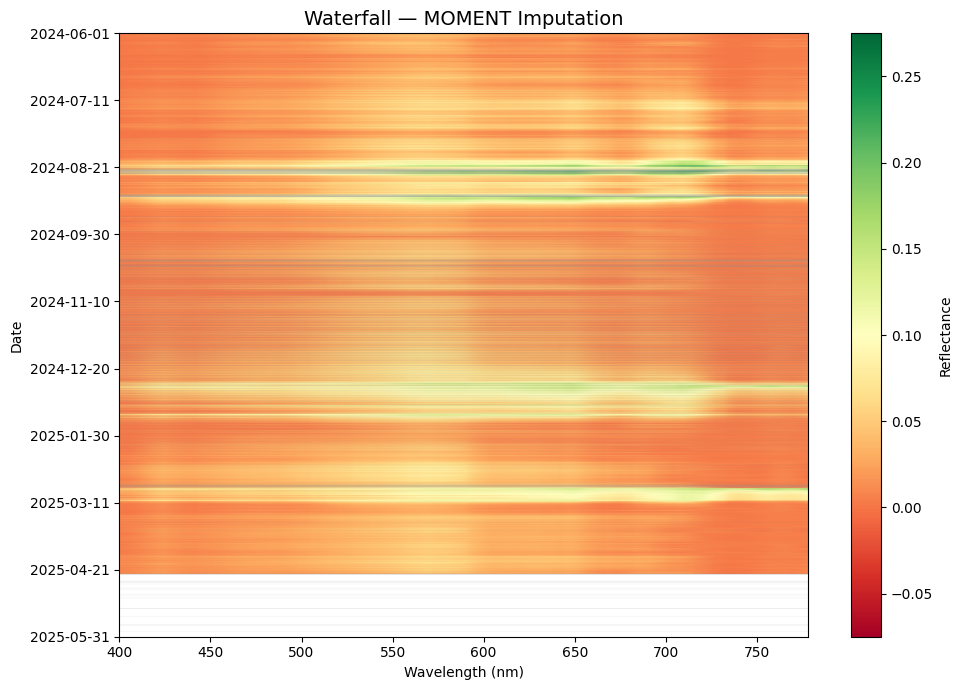

In [4]:
plot_reflectance_heatmap(df, title="Waterfall — MOMENT Imputation")

In [5]:
def interpolate_spectrum_fill_all(y, smooth=True, window=15, poly=3):
    """
    y: 1D array of shape (n_wavelengths,), may contain np.nan.
    Fills *all* gaps (NaNs) in a partially valid spectrum.

    - uses linear interpolation along wavelength
    - extrapolates edges with nearest valid value
    - optional Savitzky–Golay smoothing on the filled curve
    """
    y = y.astype(float)
    x = np.arange(len(y))

    mask = ~np.isnan(y)
    n_valid = mask.sum()

    # No or almost no information → return as is (still NaN)
    if n_valid < 2:
        return y

    x_valid = x[mask]
    y_valid = y[mask]

    # Linear interpolation + edge extrapolation
    # np.interp fills interior by interpolation and outside with boundary values
    y_filled = np.interp(x, x_valid, y_valid)

    if smooth:
        # apply gentle smoothing on the fully filled curve
        if len(y_filled) >= window:
            y_smooth = savgol_filter(y_filled, window_length=window, polyorder=poly)
            return y_smooth
        else:
            # not enough points for this window length
            return y_filled

    return y_filled

# df: your original DataFrame
# spec_cols: list of spectral_bin_* columns, e.g.:
# spec_cols = [c for c in df.columns if c.startswith("spectral_bin_")]

df_processed = df.copy()

is_fully_nan = df_processed[spec_cols].isna().all(axis=1)
is_partially_nan = df_processed[spec_cols].isna().any(axis=1) & ~is_fully_nan

rows_to_work_on = df_processed[is_partially_nan].index

for idx in rows_to_work_on:
    row = df_processed.loc[idx, spec_cols].to_numpy(dtype=float)

    # fill all gaps in that row across all bins
    row_filled = interpolate_spectrum_fill_all(
        row,
        smooth=True,   # set to False if you don’t want smoothing
        window=15,
        poly=3
    )

    df_processed.loc[idx, spec_cols] = row_filled

print("Per-row interpolation complete (all gaps filled in partial rows).")

# Keep fully-NaN rows as they are
df_ready_for_moment = df_processed.sort_values("timestamp").reset_index(drop=True)

print("\nData is now ready.")
print(f"Total rows: {len(df_ready_for_moment)}")
print(
    "Rows with full gaps (still NaN):",
    df_ready_for_moment[spec_cols].isna().all(axis=1).sum()
)

df = df_ready_for_moment.copy()
df

Per-row interpolation complete (all gaps filled in partial rows).

Data is now ready.
Total rows: 16425
Rows with full gaps (still NaN): 2059


,timestamp,400,401,402,403,404,405,406,407,408,...,769,770,771,772,773,774,775,776,777,778
0,2024-06-01 07:00:00+07:00,0.001080,0.000751,0.000507,0.000341,0.000246,0.000217,0.000249,0.000334,0.000466,...,0.005438,0.005187,0.004836,0.004382,0.003819,0.003146,0.002357,0.001449,0.000418,-0.000740
1,2024-06-01 07:15:00+07:00,0.000549,0.000239,0.000008,-0.000149,-0.000238,-0.000264,-0.000233,-0.000150,-0.000021,...,0.004390,0.004019,0.003586,0.003093,0.002546,0.001947,0.001301,0.000610,-0.000121,-0.000890
2,2024-06-01 07:30:00+07:00,0.001223,0.001235,0.001246,0.001254,0.001261,0.001265,0.001268,0.001270,0.001269,...,0.006886,0.006880,0.006877,0.006877,0.006881,0.006889,0.006901,0.006917,0.006937,0.006961
3,2024-06-01 07:45:00+07:00,0.000463,0.000454,0.000445,0.000438,0.000431,0.000426,0.000422,0.000420,0.000420,...,0.003022,0.002646,0.002314,0.002047,0.001863,0.001783,0.001825,0.002008,0.002354,0.002880
4,2024-06-01 08:00:00+07:00,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,0.002539,...,0.002949,0.003204,0.003517,0.003893,0.004338,0.004856,0.005452,0.006133,0.006903,0.007768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16420,2025-05-31 17:00:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16421,2025-05-31 17:15:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16422,2025-05-31 17:30:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16423,2025-05-31 17:45:00+07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


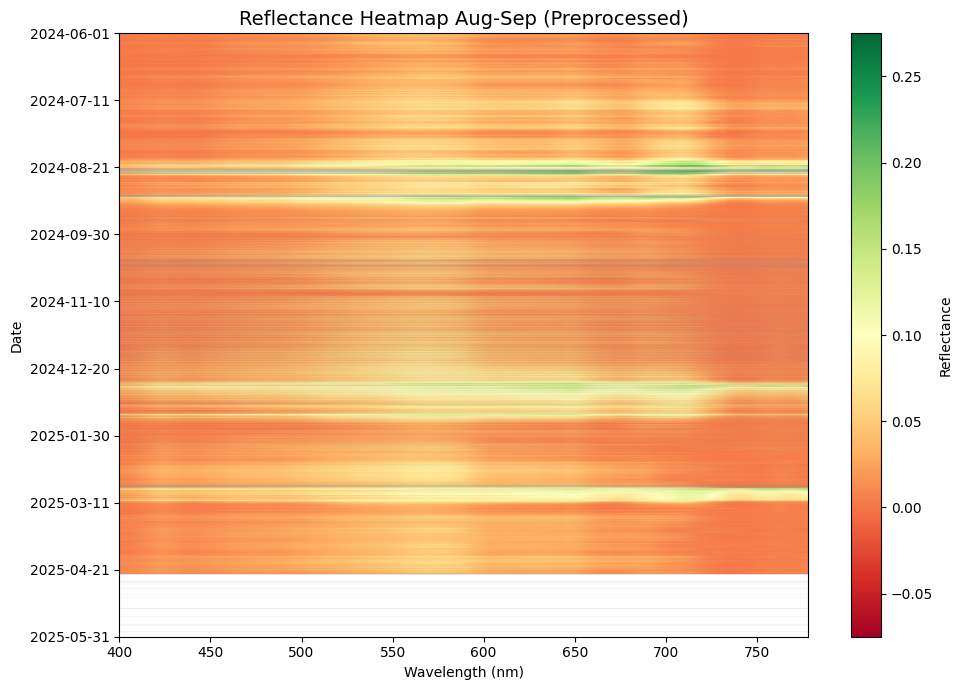

In [6]:
plot_reflectance_heatmap(
    df,
    title="Reflectance Heatmap Aug-Sep (Preprocessed)",
)

In [ ]:
#df = df_all.copy()                          # your merged dataframe
df = df_ready_for_moment.sort_values("timestamp").set_index("timestamp")

# A. choose your spectral channels
spec_cols = [c for c in df.columns if c != "timestamp"]
T = len(df)

# B. build a uniform time grid (if not already)
#df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="15min"))

# C. per-channel z-score stats (ignore NaN)
mu = np.nanmean(df[spec_cols].values, axis=0)
sd = np.nanstd(df[spec_cols].values, axis=0) + 1e-6

X_spec = df[spec_cols].values.astype(np.float32)         # [T, C]
mask_spec = np.isnan(X_spec)                             # True where missing
X_fill = np.nan_to_num(X_spec, nan=0.0)                  # temporary fill for encoder
# X_norm = (X_fill - mu) / sd                              # z-score per channel

# D. windowing (MOMENT examples use length=512; choose a value that covers gaps)
win = 512
stride = win          # non-overlapping; you can use smaller stride for overlap
starts = np.arange(0, T - win + 1, stride)

# E. build batched tensors (with padding and overlap)
Xs = []
Ms = []

# Pad the series to be a multiple of the stride for easier windowing
if T % stride != 0:
    pad_len = stride - (T % stride)
    X_fill_padded = np.pad(X_fill, ((0, pad_len), (0, 0)), 'constant', constant_values=0)
    mask_spec_padded = np.pad(mask_spec, ((0, pad_len), (0, 0)), 'constant', constant_values=True) # Pad with True (missing)
else:
    X_fill_padded = X_fill
    mask_spec_padded = mask_spec

T_padded = X_fill_padded.shape[0]
starts = np.arange(0, T_padded - win + 1, stride)

for s in starts:
    seg = X_fill_padded[s:s+win, :]      # [win, C]
    mseg = mask_spec_padded[s:s+win, :]  # [win, C]
    
    # Reshape to [B, n_channels, T] = [1, C, win] → then flatten channels
    seg = np.transpose(seg, (1, 0))      # [C, win]
    mseg = np.transpose(mseg, (1, 0))    # [C, win]
    Xs.append(seg[:, None, :])           # [C, 1, win]
    Ms.append(mseg[:, None, :])          # [C, 1, win]

X_batch = np.concatenate(Xs, axis=0)     # [sum_windows*C, 1, win]
M_batch = np.concatenate(Ms, axis=0)     # same shape, bool

# F) load MOMENT and run inference (This part is correct)
pipe = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-base",
    model_kwargs={"task_name": "reconstruction"}
)
pipe.init()
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = pipe.to(device).float()
pipe.eval()

# 1 for observed, 0 for missing
pretrain_mask = (~M_batch).astype(np.int64)
pretrain_mask = torch.tensor(pretrain_mask.squeeze(1), device=device) # [B*, win]

# Attend everywhere
input_mask = torch.ones_like(pretrain_mask)

with torch.no_grad():
    x_enc = torch.tensor(X_batch, dtype=torch.float32, device=device) # [B*, 1, win]
    out = pipe(x_enc=x_enc, input_mask=input_mask, mask=pretrain_mask)

recon = out.reconstruction.detach().cpu().numpy() # [B*, 1, win]
recon = recon.squeeze(1)                           # -> [B*, win]

# --- Corrected Stitching (with overlap handling) ---
imputed_padded = np.zeros_like(X_fill_padded)
counts = np.zeros_like(X_fill_padded)
ptr = 0

for s in starts:
    # Extract the block of imputed windows for all channels
    block = recon[ptr : ptr + len(spec_cols), :]  # [C, win]
    block = block.T                              # -> [win, C]
    
    # Add the imputed values to the corresponding slice and update the count
    imputed_padded[s : s + win, :] += block
    counts[s : s + win, :] += 1
    
    ptr += len(spec_cols)

# Average the contributions in the overlapping regions
# Add a small epsilon to counts to avoid division by zero
imputed_padded /= (counts + 1e-8)

# Remove padding to match original length
imputed = imputed_padded[:T, :]

# --- Finalize Imputation ---
# Fill only the originally missing values
filled = X_spec.copy()
filled[mask_spec] = imputed[mask_spec]

# Back to DataFrame
df_imputed = df.copy()
# Ensure imputed values are non-negative (reflectance cannot be negative)
df_imputed[spec_cols] = np.clip(filled, 0, None)

In [ ]:
df_imputed[spec_cols].isna().sum().sum() # make sure no NaNs remain
df_imputed

In [ ]:
df_imputed.to_csv("imputed_MOMENT_without_finetune.csv", index=True)

In [ ]:
df_imputed = df_imputed.reset_index()
plot_reflectance_heatmap(
    df_imputed,
    title="Reflectance Heatmap (MOMENT Imputed)",
)
